# Wen CNN 

Simulate the CNN approach of Wen et al. 2019.

Notebook 101 ran to completion on PC. Now run more epochs on CoLab.

In [6]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-08-04 12:22:44 UTC


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [8]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open('GenCodeTools.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import GenCodeLoader
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.GenCodeTools import GenCodeLoader
        from SimTools.KmerTools import KmerTools
BESTMODELPATH=DATAPATH+"BestModel-Wen"  # saved on cloud instance and lost after logout
LASTMODELPATH=DATAPATH+"LastModel-Wen"  # saved on Google Drive but requires login

On Google CoLab, mount cloud-local file, get our code from GitHub.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Data Load

In [9]:
PC_TRAINS=8000
NC_TRAINS=8000
PC_TESTS=2000
NC_TESTS=2000   
PC_LENS=(200,4000)
NC_LENS=(200,4000)   # Wen used 3500 for hyperparameter, 3000 for train
PC_FILENAME='gencode.v26.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v26.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
MAX_K = 3 
# With K={1,2,3}, num K-mers is 4^3 + 4^2 + 4^1 = 84.
# Wen specified 17x20 which is impossible.
# The factors of 84 are 1, 2, 3, 4, 6, 7, 12, 14, 21, 28, 42 and 84.
FRQ_CNT=84
ROWS=7
COLS=FRQ_CNT//ROWS
SHAPE2D = (ROWS,COLS,1)
EPOCHS=100 # 1000 # 200
SPLITS=5
FOLDS=5   # make this 5 for serious testing
show_time()

2021-08-04 12:22:44 UTC


In [10]:
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_utr(True)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))
show_time()

PC seqs loaded: 60604
NC seqs loaded: 27720
2021-08-04 12:22:52 UTC


In [11]:
def dataframe_length_filter(df,low_high):
    (low,high)=low_high
    # The pandas query language is strange, 
    # but this is MUCH faster than loop & drop.
    return df[ (df['seqlen']>=low) & (df['seqlen']<=high) ]
def dataframe_extract_sequence(df):
    return df['sequence'].tolist()

pc_all = dataframe_extract_sequence(
    dataframe_length_filter(pcdf,PC_LENS))
nc_all = dataframe_extract_sequence(
    dataframe_length_filter(ncdf,NC_LENS))

show_time()
print("PC seqs pass filter:",len(pc_all))
print("NC seqs pass filter:",len(nc_all))
# Garbage collection to reduce RAM footprint
pcdf=None
ncdf=None

2021-08-04 12:22:52 UTC
PC seqs pass filter: 49180
NC seqs pass filter: 26850


## Data Prep

In [12]:
pc_train=pc_all[:PC_TRAINS] 
nc_train=nc_all[:NC_TRAINS]
print("PC train, NC train:",len(pc_train),len(nc_train))
pc_test=pc_all[PC_TRAINS:PC_TRAINS+PC_TESTS] 
nc_test=nc_all[NC_TRAINS:NC_TRAINS+PC_TESTS]
print("PC test, NC test:",len(pc_test),len(nc_test))
# Garbage collection
pc_all=None
nc_all=None

PC train, NC train: 8000 8000
PC test, NC test: 2000 2000


In [13]:
def prepare_x_and_y(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    total=len1+len0
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_labels = np.concatenate((L1,L0))
    all_seqs = np.concatenate((S1,S0))  
    # interleave (uses less RAM than shuffle)
    for i in range(0,len0):
        all_labels[i*2] = L0[i]
        all_seqs[i*2] = S0[i]
        all_labels[i*2+1] = L1[i]
        all_seqs[i*2+1] = S1[i]
    return all_seqs,all_labels  # use this to test unshuffled
    X,y = shuffle(all_seqs,all_labels) # sklearn.utils.shuffle 
    return X,y
Xseq,y=prepare_x_and_y(pc_train,nc_train)
#print(Xseq[:3])
#print(y[:3])
show_time()

2021-08-04 12:22:52 UTC


In [14]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    collection = []
    for seq in seqs:
        counts = tool.make_dict_upto_K(max_K)
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
# Garbage collection
Xseq = None
show_time()

2021-08-04 12:23:03 UTC


In [15]:
def reshape(frequency_matrix):
    seq_cnt,frq_cnt=Xfrq.shape 
    # CNN inputs require a last dimension = numbers per pixel.
    # For RGB images it is 3.
    # For our frequency matrix it is 1.
    new_matrix = frequency_matrix.reshape(seq_cnt,ROWS,COLS,1)
    return new_matrix

print("Xfrq")
print("Xfrq type",type(Xfrq))
print("Xfrq shape",Xfrq.shape)
Xfrq2D = reshape(Xfrq)
print("Xfrq2D shape",Xfrq2D.shape)

Xfrq
Xfrq type <class 'numpy.ndarray'>
Xfrq shape (16000, 84)
Xfrq2D shape (16000, 7, 12, 1)


## Build and train a neural network

In [16]:
def make_DNN(shape):
    dt=np.float32
    print("make_DNN")
    print("input shape:",shape)
    WIDTH=(3,3)
    STRIDE=(1,1)
    dnn = Sequential()
    dnn.add(Conv2D(filters=32,kernel_size=WIDTH,strides=STRIDE,activation="relu",padding="same",
            input_shape=shape))
    dnn.add(Conv2D(filters=64,kernel_size=WIDTH,strides=STRIDE,activation="relu",padding="same"))
    dnn.add(MaxPooling2D())
    dnn.add(Flatten())
    dnn.add(Dropout(0.25))
    dnn.add(Dense(128,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(0.50))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    # adadelta doesn't work as well
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=shape) 
    return dnn
model = make_DNN(SHAPE2D)
print(model.summary())

make_DNN
input shape: (7, 12, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 12, 32)         320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 12, 64)         18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    
_________________________________________________________________
dropout_1 (Dropout)    

In [17]:
def do_cross_validation(X,y,shape):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=BESTMODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    splitter = KFold(n_splits=SPLITS,shuffle=True) 
    model = None
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN(shape)
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

2021-08-04 12:23:07 UTC
MODEL
make_DNN
input shape: (7, 12, 1)
FIT
Epoch 1/100
400/400 [==============================] - 29s 4ms/step - loss: 0.7526 - accuracy: 0.5225 - val_loss: 0.6444 - val_accuracy: 0.6281
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/BestModel-Wen/assets
Epoch 2/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6392 - accuracy: 0.6324 - val_loss: 0.6064 - val_accuracy: 0.6644
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/BestModel-Wen/assets
Epoch 3/100
400/400 [==============================] - 1s 3ms/step - loss: 0.5900 - accuracy: 0.6923 - val_loss: 0.5294 - val_accuracy: 0.7475
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/BestModel-Wen/assets
Epoch 4/100
400/400 [==============================] - 1s 3ms/step - loss: 0.5280 - accuracy: 0.7442 - val_loss: 0.4594 - val_accuracy: 0.7894
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/BestModel-Wen/assets
Epoch 5/100
400/400 

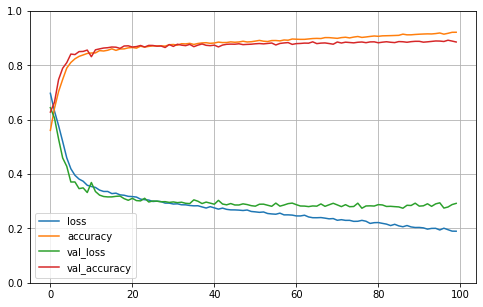

MODEL
make_DNN
input shape: (7, 12, 1)
FIT
Epoch 1/100
400/400 [==============================] - 2s 4ms/step - loss: 0.7124 - accuracy: 0.5421 - val_loss: 0.6265 - val_accuracy: 0.6388
Epoch 2/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6295 - accuracy: 0.6489 - val_loss: 0.5693 - val_accuracy: 0.6991
Epoch 3/100
400/400 [==============================] - 1s 3ms/step - loss: 0.5612 - accuracy: 0.7181 - val_loss: 0.4757 - val_accuracy: 0.7884
Epoch 4/100
400/400 [==============================] - 1s 3ms/step - loss: 0.5010 - accuracy: 0.7571 - val_loss: 0.4115 - val_accuracy: 0.8259
Epoch 5/100
400/400 [==============================] - 1s 3ms/step - loss: 0.4466 - accuracy: 0.7970 - val_loss: 0.3764 - val_accuracy: 0.8438
Epoch 6/100
400/400 [==============================] - 1s 3ms/step - loss: 0.4024 - accuracy: 0.8216 - val_loss: 0.3606 - val_accuracy: 0.8456
Epoch 7/100
400/400 [==============================] - 1s 3ms/step - loss: 0.4039 - accuracy: 0.823

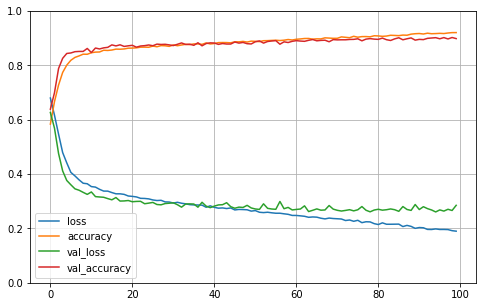

MODEL
make_DNN
input shape: (7, 12, 1)
FIT
Epoch 1/100
400/400 [==============================] - 3s 4ms/step - loss: 0.7221 - accuracy: 0.5320 - val_loss: 0.6412 - val_accuracy: 0.6228
Epoch 2/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6336 - accuracy: 0.6360 - val_loss: 0.5791 - val_accuracy: 0.7159
Epoch 3/100
400/400 [==============================] - 1s 4ms/step - loss: 0.5757 - accuracy: 0.6984 - val_loss: 0.4883 - val_accuracy: 0.7756
Epoch 4/100
400/400 [==============================] - 1s 3ms/step - loss: 0.4918 - accuracy: 0.7653 - val_loss: 0.4420 - val_accuracy: 0.7919
Epoch 5/100
400/400 [==============================] - 1s 3ms/step - loss: 0.4580 - accuracy: 0.7822 - val_loss: 0.3997 - val_accuracy: 0.8250
Epoch 6/100
400/400 [==============================] - 1s 4ms/step - loss: 0.4185 - accuracy: 0.8103 - val_loss: 0.3789 - val_accuracy: 0.8347
Epoch 7/100
400/400 [==============================] - 1s 4ms/step - loss: 0.3964 - accuracy: 0.820

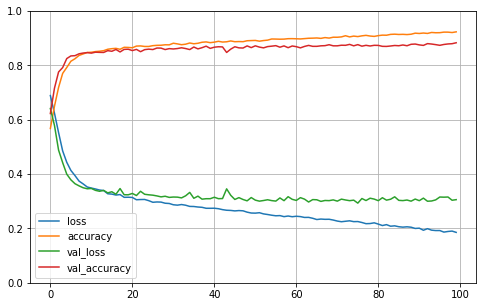

MODEL
make_DNN
input shape: (7, 12, 1)
FIT
Epoch 1/100
400/400 [==============================] - 3s 4ms/step - loss: 0.7145 - accuracy: 0.5320 - val_loss: 0.6340 - val_accuracy: 0.6309
Epoch 2/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6346 - accuracy: 0.6422 - val_loss: 0.5719 - val_accuracy: 0.7181
Epoch 3/100
400/400 [==============================] - 1s 3ms/step - loss: 0.5593 - accuracy: 0.7204 - val_loss: 0.4973 - val_accuracy: 0.7681
Epoch 4/100
400/400 [==============================] - 1s 3ms/step - loss: 0.4958 - accuracy: 0.7656 - val_loss: 0.4402 - val_accuracy: 0.8094
Epoch 5/100
400/400 [==============================] - 1s 3ms/step - loss: 0.4592 - accuracy: 0.7873 - val_loss: 0.4258 - val_accuracy: 0.8047
Epoch 6/100
400/400 [==============================] - 1s 3ms/step - loss: 0.4240 - accuracy: 0.8116 - val_loss: 0.3926 - val_accuracy: 0.8356
Epoch 7/100
400/400 [==============================] - 1s 4ms/step - loss: 0.4110 - accuracy: 0.815

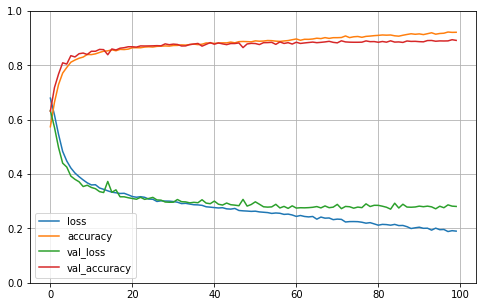

MODEL
make_DNN
input shape: (7, 12, 1)
FIT
Epoch 1/100
400/400 [==============================] - 2s 4ms/step - loss: 0.7146 - accuracy: 0.5411 - val_loss: 0.6300 - val_accuracy: 0.6472
Epoch 2/100
400/400 [==============================] - 1s 3ms/step - loss: 0.6244 - accuracy: 0.6470 - val_loss: 0.5763 - val_accuracy: 0.7172
Epoch 3/100
400/400 [==============================] - 1s 4ms/step - loss: 0.5768 - accuracy: 0.6930 - val_loss: 0.4995 - val_accuracy: 0.7650
Epoch 4/100
400/400 [==============================] - 1s 3ms/step - loss: 0.5134 - accuracy: 0.7502 - val_loss: 0.4462 - val_accuracy: 0.7919
Epoch 5/100
400/400 [==============================] - 1s 3ms/step - loss: 0.4683 - accuracy: 0.7829 - val_loss: 0.3877 - val_accuracy: 0.8297
Epoch 6/100
400/400 [==============================] - 1s 3ms/step - loss: 0.4209 - accuracy: 0.8126 - val_loss: 0.3654 - val_accuracy: 0.8438
Epoch 7/100
400/400 [==============================] - 1s 3ms/step - loss: 0.4060 - accuracy: 0.815

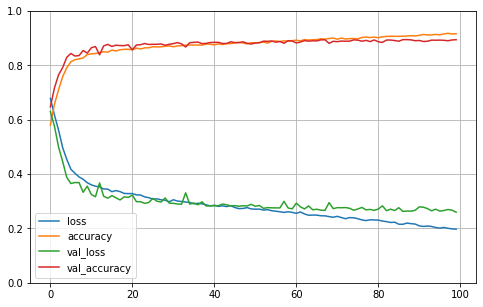

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LastModel-Wen/assets


In [18]:
show_time()
last_model = do_cross_validation(Xfrq2D,y,SHAPE2D)
last_model.save(LASTMODELPATH)

## Test the neural network

In [19]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on test data.
Prepare...
2021-08-04 12:36:14 UTC
Extract K-mer features...
2021-08-04 12:36:14 UTC
Plot...
2021-08-04 12:36:17 UTC


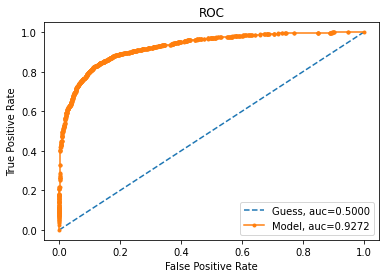

AUC: 92.72%
accuracy: 85.22%
2021-08-04 12:36:18 UTC


In [20]:
print("Accuracy on test data.")
print("Prepare...")
show_time()
Xseq,y=prepare_x_and_y(pc_test,nc_test)
print("Extract K-mer features...")
show_time()
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
Xfrq2D = reshape(Xfrq)
print("Plot...")
show_time()
show_test_AUC(last_model,Xfrq2D,y)
show_test_accuracy(last_model,Xfrq2D,y)
show_time()